# MODELO SARIMAX

### Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from itertools import count
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import statsmodels.graphics.tsaplots as sgt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 

### 1. Cargar Datos

In [2]:
file_path = r"..\Modelling\data.csv"
data = pd.read_csv(file_path)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)
data

,Ventas,Festivo,IsWeekend,DiaSemanaNum,DiaSemana_0,DiaSemana_1,DiaSemana_2,DiaSemana_3,DiaSemana_4,DiaSemana_5,DiaSemana_6,Ventas_Log,Ventas_Loess,Ventas_Log_Loess
Fecha,,,,,,,,,,,,,,
2021-11-02,80413.11,0,0,1,0,1,0,0,0,0,0,11.294945,29692.704031,10.116158
2021-11-03,14889.17,0,0,2,0,0,1,0,0,0,0,9.608457,29674.201652,10.115608
2021-11-04,50003.14,0,0,3,0,0,0,1,0,0,0,10.819861,29656.031451,10.115075
2021-11-05,39607.01,0,0,4,0,0,0,0,1,0,0,10.586787,29638.193546,10.114560
2021-11-06,0.00,0,1,5,0,0,0,0,0,1,0,0.000000,29620.685373,10.114062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,305.76,0,1,5,0,0,0,0,0,1,0,5.726066,15205.174613,9.351941
2024-07-28,114.40,0,1,6,0,0,0,0,0,0,1,4.748404,15183.946452,9.350883
2024-07-29,14466.95,0,0,0,1,0,0,0,0,0,0,9.579691,15162.718291,9.349824


In [3]:
test_days = 101 # Coincide con el train-test split del Análisis exploratorio

### 2. Train Once - Test Once

#### 2.1. Serie sin transformar

In [4]:
exog = data[['Festivo', 'IsWeekend','DiaSemana_0','DiaSemana_1','DiaSemana_2','DiaSemana_3','DiaSemana_4','DiaSemana_5','DiaSemana_6']]

In [5]:
train_data = data['Ventas'][:-test_days]
test_data = data['Ventas'][-test_days:]

# Variables exógenas
exog_train = exog[:-test_days]
exog_test = exog[-test_days:]

Del análisis exploratorio se obtuvo la siguiente gráfica:

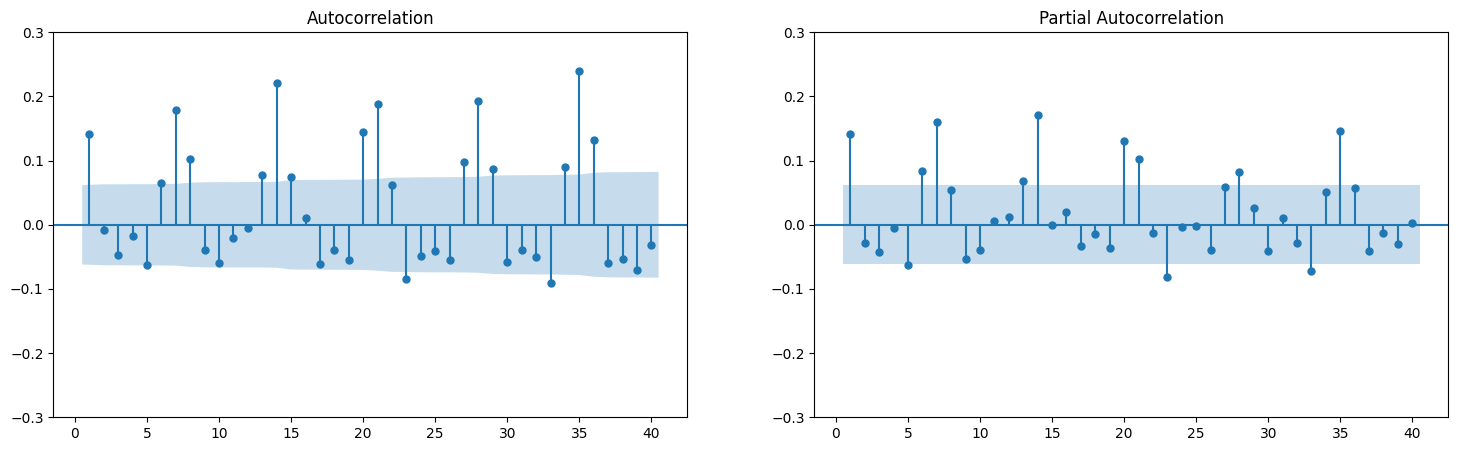

De ambas gráficas se puede apreciar un valor significativo para el primer rezago, con lo cual, valores de P y Q en un modelo básico ARIMA podrían ser de 1 y 1, respectivamente.
Adicionalmente, se observan picos cada 7 días, lo cual indica un posible componente estacional semanal. 
También, por el test de Dickey-Fuller, se concluyó que la serie es estacionaria, con lo cual no se necesita diferenciación. Sin embargo, se hará una validación con base en el AIC.

In [6]:
# Inicializar un DataFrame para almacenar los resultados
results_list = []

# Iterar sobre los valores de p, d, q para 'order'. Se probará con (1,0,1) de orden semanal para la componente estacional.
for p in range(7):
    for d in range(1):  # d = 0 en este caso, ya que es estacionario
        for q in range(7):
            try:
                # Ajustar el modelo SARIMAX
                sarimax_model = SARIMAX(train_data, 
                                        order=(p, d, q), 
                                        seasonal_order=(1, 0, 1, 7), 
                                        exog=exog_train, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                sarimax_results = sarimax_model.fit(disp=False)
                
                # Guardar el AIC y los hiperparámetros en la lista
                results_list.append({"order": (p, d, q), 
                                        "AIC": sarimax_results.aic})
            except Exception as e:
                print(f"Error con el modelo SARIMAX({p},{d},{q}): {e}")

results_df = pd.DataFrame(results_list)

# Encontrar el mejor modelo con base en el AIC
best_model = results_df.loc[results_df["AIC"].idxmin()]

print("El mejor modelo es:")
print(best_model)

El mejor modelo es:
order       (3, 0, 6)
AIC      20223.500544
Name: 27, dtype: object


In [7]:
best_order = best_model["order"]
# Ajustar el modelo SARIMAX con estacionalidad semanal (7 días)
sarimax_model = SARIMAX(train_data, 
                        order=best_order, 
                        seasonal_order=(1, 0, 1, 7), 
                        exog=exog_train, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit()

In [ ]:
# Predicciones en el conjunto de entrenamiento
train_predictions = sarimax_results.get_prediction(start=0, end=len(train_data)-1, exog=exog_train)
train_forecast_values = train_predictions.predicted_mean
y_pred_train = np.clip(train_forecast_values, 0, None)

# Realizar predicciones para test
test_predictions = sarimax_results.get_forecast(steps=test_days, exog=exog_test)
test_forecast_values = test_predictions.predicted_mean
y_pred_test = np.clip(test_forecast_values, 0, None)

Comparando los valores reales con la predicción:

In [ ]:
# Comparar predicciones ajustadas en train y test con los valores reales
train_vs_actual = pd.DataFrame({
    'Actual': train_data,
    'Forecast': y_pred_train
})

# Calcular métricas de error en train
rmse_train_1 = np.sqrt(mean_squared_error(train_data, y_pred_train))
r2_train_1 = r2_score(train_data, y_pred_train)
mae_train_1 = mean_absolute_error(train_data, y_pred_train)

print(f'Predicciones en train:\n {train_vs_actual}')
print(f'RMSE (train): {rmse_train_1}')
print(f'R² (train): {r2_train_1}')
print(f'MAE (train): {mae_train_1}')

test_vs_actual = pd.DataFrame({
    'Actual': test_data,
    'Forecast': y_pred_test
})

# Calcular métricas de error en test
rmse_test = np.sqrt(mean_squared_error(test_data, y_pred_test))
r2_test = r2_score(test_data, y_pred_test)
mae_test = mean_absolute_error(test_data, y_pred_test)

print(f'Predicciones en test: \n{test_vs_actual}')
print(f'RMSE (test): {rmse_test}')
print(f'R² (test): {r2_test}')
print(f'MAE (test): {mae_test}')

Predicciones en train:
               Actual      Forecast
2021-11-02  80413.11  39515.613006
2021-11-03  14889.17  52512.979929
2021-11-04  50003.14  21153.137274
2021-11-05  39607.01  67728.987741
2021-11-06      0.00  24965.231517
...              ...           ...
2024-04-17  12783.88  23350.337557
2024-04-18     74.88  33122.685447
2024-04-19  12122.84  25110.655793
2024-04-20      0.00      0.000000
2024-04-21      0.00      0.000000

[902 rows x 2 columns]
RMSE (train): 20704.87839449261
R² (train): 0.4508327809807866
MAE (train): 15358.540698134691
Predicciones en test: 
              Actual      Forecast
2024-04-22   1306.55  27212.712299
2024-04-23   2806.47  22632.487774
2024-04-24  32148.73  31025.960656
2024-04-25  64399.20  39316.806940
2024-04-26  10158.35  34444.658239
...              ...           ...
2024-07-27    305.76   5693.197696
2024-07-28    114.40   2190.275510
2024-07-29  14466.95  37704.300473
2024-07-30  29984.35  39393.301263
2024-07-31  15335.34  39856.4

In [11]:
# Almacenar la información del modelo
model_info = {
    'version': 'SARIMAX Train Once - Test Once',
    'model_name': sarimax_model.__class__.__name__,
    'rmse_train': rmse_train_1,
    'mae_train':mae_train_1,
    'r2_train': r2_train_1,
    'rmse_test': rmse_test,
    'mae_test':mae_test,
    'r2_test': r2_test,
    }

In [12]:
df_models_info = pd.DataFrame([model_info])
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,SARIMAX Train Once - Test Once,SARIMAX,20704.878394,15358.540698,0.450833,19801.859145,14742.087057,0.424


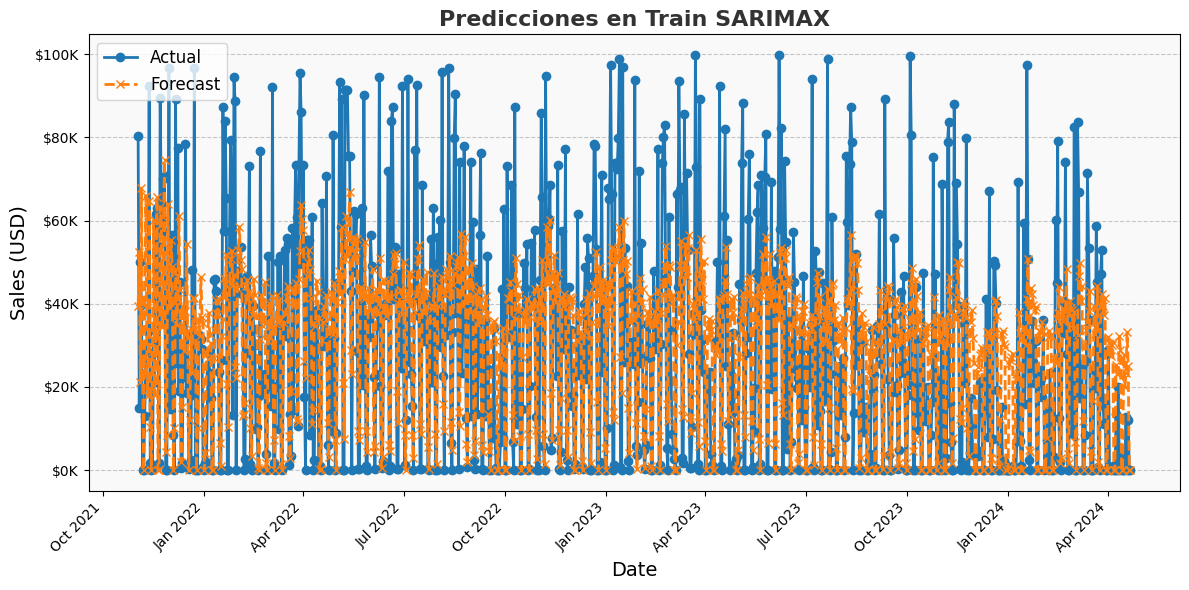

In [ ]:
# Graficar los valores reales vs predicciones ajustadas
plt.figure(figsize=(12, 6))
plt.plot(train_vs_actual.index, train_vs_actual['Actual'], 
         label='Actual', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
plt.plot(train_vs_actual.index, train_vs_actual['Forecast'], 
         label='Forecast', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
plt.title('Predicciones en Train SARIMAX', 
          fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales (USD)', fontsize=14)

# Formato de ejes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right', fontsize=10)
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_tick_params(labelsize=10)

plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

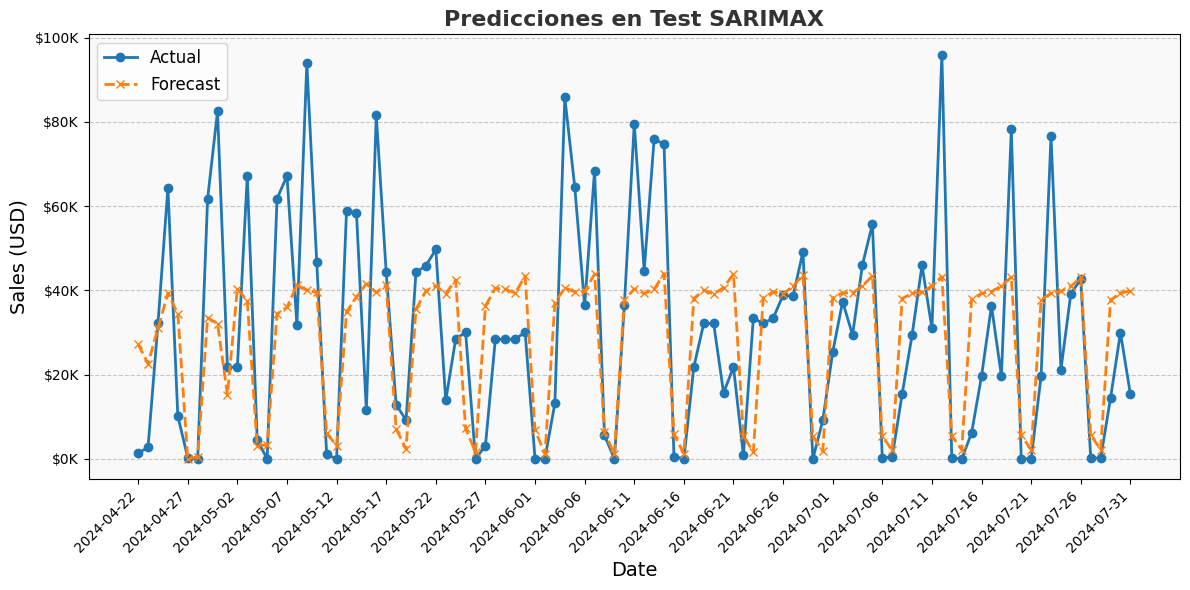

In [14]:
# Graficar los valores reales vs predicciones ajustadas
plt.figure(figsize=(12, 6))
plt.plot(test_vs_actual.index, test_vs_actual['Actual'], 
         label='Actual', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
plt.plot(test_vs_actual.index, test_vs_actual['Forecast'], 
         label='Forecast', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
plt.title('Predicciones en Test SARIMAX', 
          fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales (USD)', fontsize=14)
plt.xticks(test_vs_actual.index[::5], rotation=45, ha='right', fontsize=10)
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
def plot_predictions(y_pred_train, y_pred_test, data, model_info, test_days):
    """
    Graficar predicciones y valores reales con una línea divisoria para separar train y test.

    Parameters:
    - y_pred_train: Predicciones del conjunto de entrenamiento.
    - y_pred_test: Predicciones del conjunto de prueba.
    - data: DataFrame con los valores reales ('Ventas').
    - model_info: Diccionario con información del modelo, debe incluir la clave 'version'.
    - test_days: Número de días en el conjunto de prueba (default: 101).
    """
    # Generar df para almacenar predicciones y usar los últimos 200 días
    predictions = pd.concat([y_pred_train, y_pred_test], axis=0).to_frame(name='Predicted')
    predictions['Actual'] = data.loc[predictions.index, 'Ventas']
    test_start_index = predictions.index[-test_days]

    predictions_last_200 = predictions.tail(200)
    plt.figure(figsize=(12, 6))
    # Graficar train y test
    plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Actual'],
             label='Actual - Train', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
    plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Predicted'],
             label='Forecast - Train', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
    plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Actual'],
             label='Actual - Test', marker='o', color='#2ca02c', linewidth=2, linestyle='-')
    plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Predicted'],
             label='Forecast - Test', marker='x', color='#d62728', linewidth=2, linestyle='--')

    # Configurar formato
    plt.axvline(test_start_index, color='gray', linestyle='--', linewidth=1.5)
    plt.title(f"Predicciones {model_info['version']} (Últimos 200 días)", fontsize=16, fontweight='bold', color='#333')
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Ventas (USD)', fontsize=14)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('#f9f9f9')
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

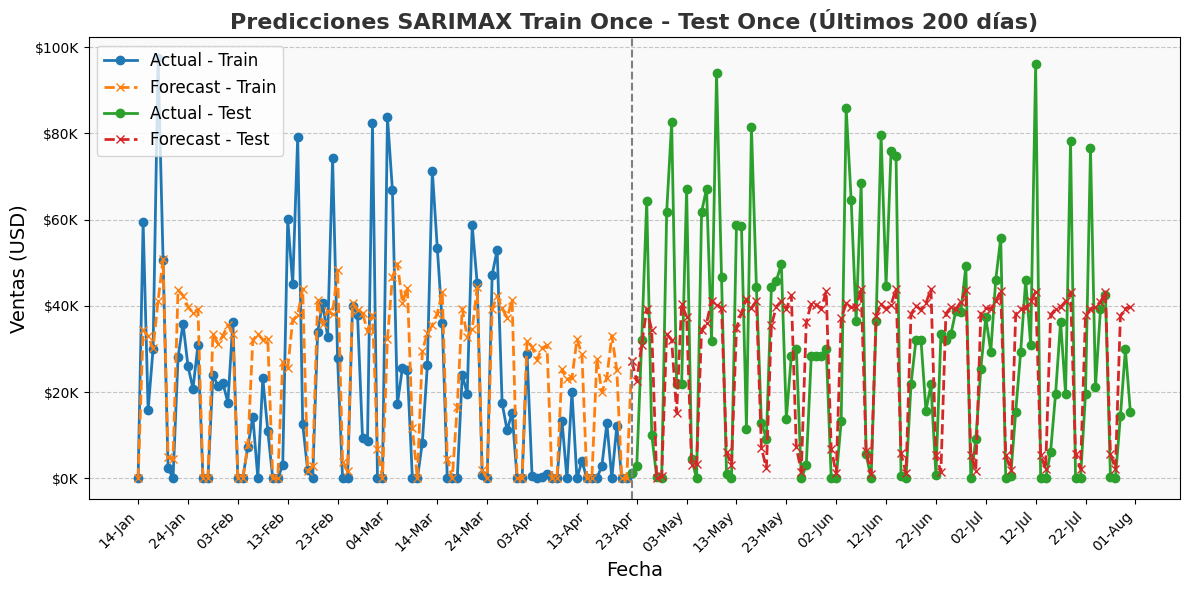

In [16]:
# Gráfica comparativa SARIMAX
plot_predictions(y_pred_train, y_pred_test, data, model_info,test_days=test_days)

#### 2.2. Serie transformada (Log) 

In [17]:
exog_Log = data[['Festivo', 'IsWeekend','DiaSemana_0','DiaSemana_1','DiaSemana_2','DiaSemana_3','DiaSemana_4','DiaSemana_5','DiaSemana_6']]

In [18]:
train_data_log = data['Ventas_Log'][:-test_days]
test_data_log = data['Ventas_Log'][-test_days:]

# Variables exógenas
exog_train_log = exog_Log[:-test_days]
exog_test_log = exog_Log[-test_days:]

In [19]:
# Inicializar un DataFrame para almacenar los resultados
results_list = []

# Iterar sobre los valores de p, d, q para 'order'. Se probará con (1,0,1) de orden semanal para la componente estacional.
for p in range(7):
    for d in range(1):  # d = 0 en este caso, ya que es estacionario
        for q in range(7):
            try:
                # Ajustar el modelo SARIMAX
                sarimax_model = SARIMAX(train_data_log, 
                                        order=(p, d, q), 
                                        seasonal_order=(1, 0, 1, 7), 
                                        exog=exog_train_log, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                sarimax_results = sarimax_model.fit(disp=False)
                
                # Guardar el AIC y los hiperparámetros en la lista
                results_list.append({"order": (p, d, q), 
                                        "AIC": sarimax_results.aic})
            except Exception as e:
                print(f"Error con el modelo SARIMAX({p},{d},{q}): {e}")

# Convertir la lista a DataFrame
results_df = pd.DataFrame(results_list)

# Ordenar el DataFrame por AIC para encontrar el mejor modelo
best_model = results_df.loc[results_df["AIC"].idxmin()]

print("El mejor modelo es:")
print(best_model)

El mejor modelo es:
order      (1, 0, 6)
AIC      3999.819212
Name: 13, dtype: object


In [20]:
best_order_log = best_model["order"]

# Ajustar el modelo SARIMAX con estacionalidad semanal (7 días)
sarimax_model_log = SARIMAX(train_data_log, 
                        order=best_order_log, 
                        seasonal_order=(1, 0, 1, 7), 
                        exog=exog_train_log,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_results_log = sarimax_model_log.fit()
sarimax_results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Ventas_Log   No. Observations:                  902
Model:             SARIMAX(1, 0, 6)x(1, 0, [1], 7)   Log Likelihood               -1980.910
Date:                             Thu, 05 Dec 2024   AIC                           3999.819
Time:                                     19:13:03   BIC                           4090.810
Sample:                                 11-02-2021   HQIC                          4034.601
                                      - 04-21-2024                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Festivo        -2.1803      0.431     -5.054      0.000      -3.026      -1.335
IsWeekend       2.2380      0.176     12.719      0.000       1.893       2.583
DiaSemana_0     9.8900      0.506     19.536      0.000       8.898      10.882
DiaSemana_1    10.1162      0.492     20.570      0.000       9.152      11.080
DiaSemana_2    10.0332      0.486     20.642      0.000       9.081      10.986
DiaSemana_3    10.1630      0.637     15.950      0.000       8.914      11.412
DiaSemana_4    10.1936      0.511     19.932      0.000       9.191      11.196
DiaSemana_5     2.0707      0.136     15.245      0.000       1.804       2.337
DiaSemana_6     0.1672      0.131      1.281      0.200      -0.089       0.423
ar.L1           0.8915      0.049     18.326      0.000       0.796       0.987
ma.L1          -0.8332      0.057    -14.499      0.000      -0.946      -0.721
ma.L2           0.0658      0.050      1.308      0.191      -0.033       0.164
ma.L3          -0.0255      0.063     -0.404      0.687      -0.149       0.098
ma.L4           0.0201      0.067      0.300      0.764      -0.111       0.151
ma.L5           0.0035      0.067      0.053      0.958      -0.127       0.134
ma.L6           0.0564      0.048      1.173      0.241      -0.038       0.151
ar.S.L7        -0.7338      0.055    -13.378      0.000      -0.841      -0.626
ma.S.L7         0.8262      0.047     17.715      0.000       0.735       0.918
sigma2          4.9901      0.196     25.469      0.000       4.606       5.374
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               475.06
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.37
Prob(H) (two-sided):                  0.78   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+18. Standard errors may be unstable.
"""

In [21]:
# Realizar predicciones en el conjunto de entrenamiento con límite inferior y superior
train_predictions = sarimax_results_log.get_prediction(start=0, end=len(train_data_log)-1, exog=exog_train_log)
train_forecast_values = train_predictions.predicted_mean
train_forecast_values_clipped = np.clip(train_forecast_values, 0, 12.77) #El valor de (Ln 130.000)+1 es cercano a 12.77 (límite superior establecido).

# Reversar transformación logarítmica en train
train_forecast_values_clipped = np.exp(train_forecast_values_clipped) - 1

# Realizar predicciones en el conjunto de prueba con límite inferior
predictions = sarimax_results_log.get_forecast(steps=test_days, exog=exog_test_log)
forecast_values = predictions.predicted_mean
forecast_values_clipped = np.clip(forecast_values, 0, 12.77)

#Reversar transformación logarítmica
test_data_original = np.exp(test_data_log) - 1
test_forecast_values_clipped = np.exp(forecast_values_clipped) - 1

In [ ]:
# Comparar predicciones ajustadas en train y test con los valores reales
train_vs_actual_2 = pd.DataFrame({
    'Actual': train_data,
    'Forecast': train_forecast_values_clipped
})

#  Calcular métricas de error en train
rmse_train_2 = np.sqrt(mean_squared_error(train_data, train_forecast_values_clipped))
r2_train_2 = r2_score(train_data, train_forecast_values_clipped)
mae_train_2 = mean_absolute_error(train_data, train_forecast_values_clipped)

print(f'Predicciones en train:\n {train_vs_actual_2}')
print(f'RMSE (train): {rmse_train_2}')
print(f'R² (train): {r2_train_2}')
print(f'MAE (train): {mae_train_2}')

test_vs_actual = pd.DataFrame({
    'Actual': test_data,
    'Forecast': test_forecast_values_clipped
})

#  Calcular métricas de error en test
rmse_test = np.sqrt(mean_squared_error(test_data, test_forecast_values_clipped))
r2_test = r2_score(test_data, test_forecast_values_clipped)
mae_test = mean_absolute_error(test_data, test_forecast_values_clipped)

print(f'Predicciones en test: \n{test_vs_actual}')
print(f'RMSE (test): {rmse_test}')
print(f'R² (test): {r2_test}')
print(f'MAE (test): {mae_test}')


Predicciones en train:
               Actual      Forecast
2021-11-02  80413.11  24739.455846
2021-11-03  14889.17  65125.143033
2021-11-04  50003.14  17753.555911
2021-11-05  39607.01  48008.223901
2021-11-06      0.00    104.555367
...              ...           ...
2024-04-17  12783.88   4161.496282
2024-04-18     74.88   1634.456942
2024-04-19  12122.84   3547.133188
2024-04-20      0.00      5.604339
2024-04-21      0.00      0.720289

[902 rows x 2 columns]
RMSE (train): 27199.61471925769
R² (train): 0.05226975225345887
MAE (train): 17453.110903562087
Predicciones en test: 
              Actual      Forecast
2024-04-22   1306.55   1809.616196
2024-04-23   2806.47   7484.844036
2024-04-24  32148.73   2171.580405
2024-04-25  64399.20   6946.508365
2024-04-26  10158.35   6273.131408
...              ...           ...
2024-07-27    305.76     73.289180
2024-07-28    114.40     10.105182
2024-07-29  14466.95  19624.755448
2024-07-30  29984.35  24890.582116
2024-07-31  15335.34  22574.

In [23]:
# Almacenar la información del modelo
model_info = {
    'version': 'SARIMAX log Train Once Test Once',
    'model_name': sarimax_model.__class__.__name__,
    'rmse_train': rmse_train_2,
    'mae_train':mae_train_2,
    'r2_train': r2_train_2,
    'rmse_test': rmse_test,
    'mae_test':mae_test,
    'r2_test': r2_test,
}

In [24]:
# Agregar al dataframe
df_models_info = pd.concat([df_models_info, pd.DataFrame([model_info])], ignore_index=True)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,SARIMAX Train Once - Test Once,SARIMAX,20704.878394,15358.540698,0.450833,19801.859145,14742.087057,0.424000
1,SARIMAX log Train Once Test Once,SARIMAX,27199.614719,17453.110904,0.052270,26493.538408,17565.065774,-0.031075


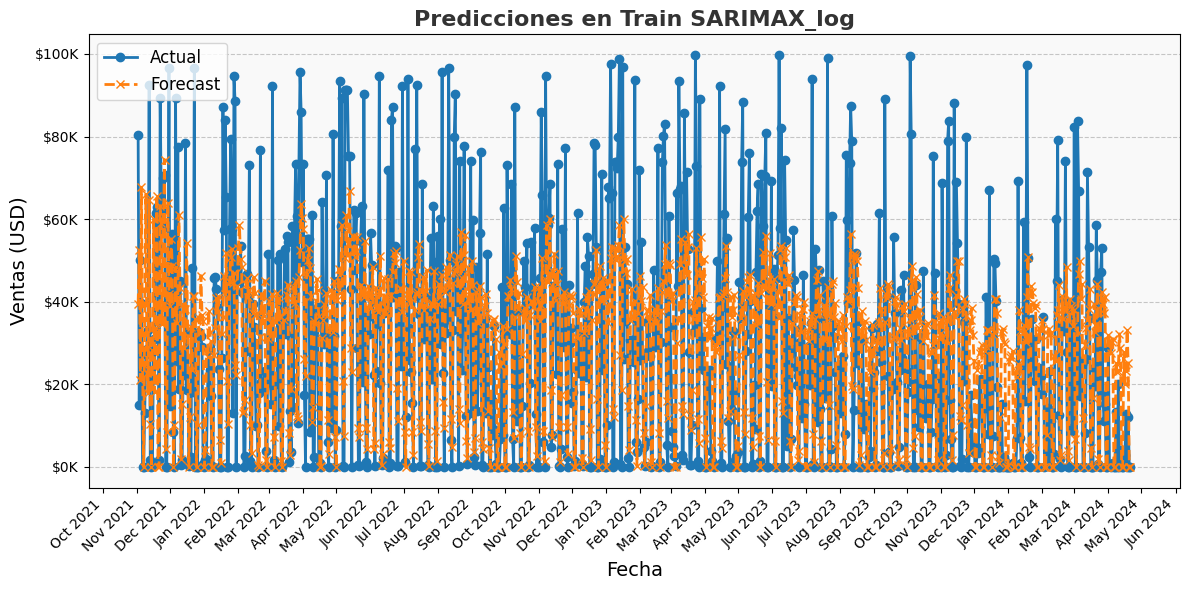

In [ ]:
plt.figure(figsize=(12, 6))

# Graficar los valores reales y las predicciones en el conjunto de entrenamiento
plt.plot(train_vs_actual.index, train_vs_actual['Actual'], 
         label='Actual', marker='o', color='#1f77b4', linewidth=2, linestyle='-')

plt.plot(train_vs_actual.index, train_vs_actual['Forecast'], 
         label='Forecast', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')

plt.title('Predicciones en Train SARIMAX_log', 
          fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Ventas (USD)', fontsize=14)

# Configuraciones de formato
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right', fontsize=10)
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

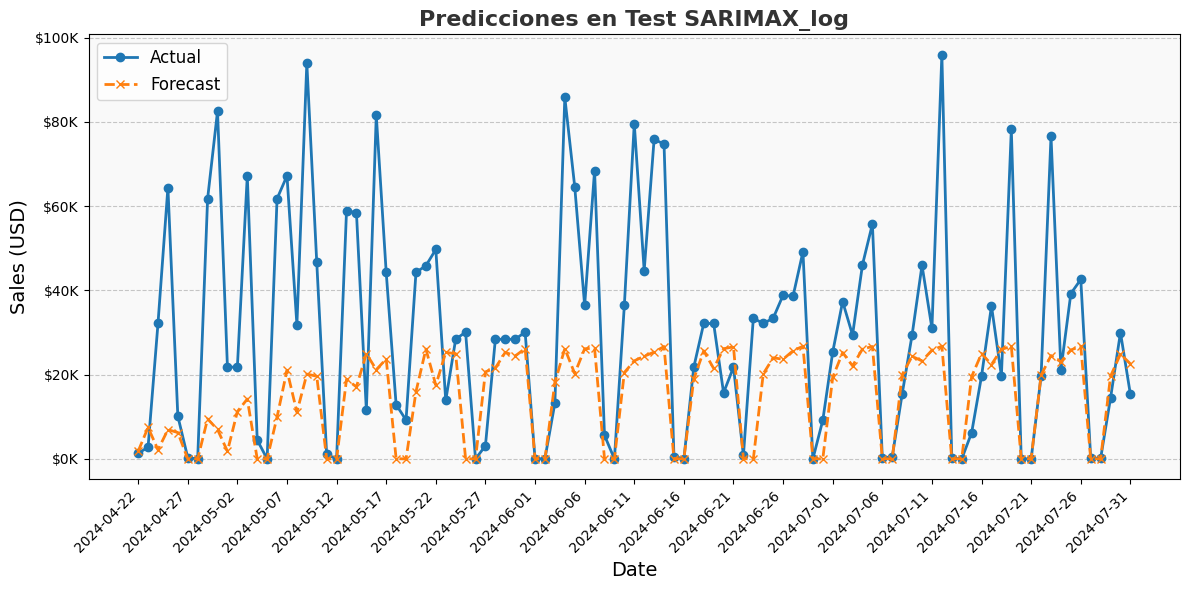

In [26]:
# Graficar los valores reales vs predicciones ajustadas
plt.figure(figsize=(12, 6))
plt.plot(test_vs_actual.index, test_vs_actual['Actual'], 
         label='Actual', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
plt.plot(test_vs_actual.index, test_vs_actual['Forecast'], 
         label='Forecast', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
plt.title('Predicciones en Test SARIMAX_log', 
          fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales (USD)', fontsize=14)
plt.xticks(test_vs_actual.index[::5], rotation=45, ha='right', fontsize=10)
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_tick_params(labelsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

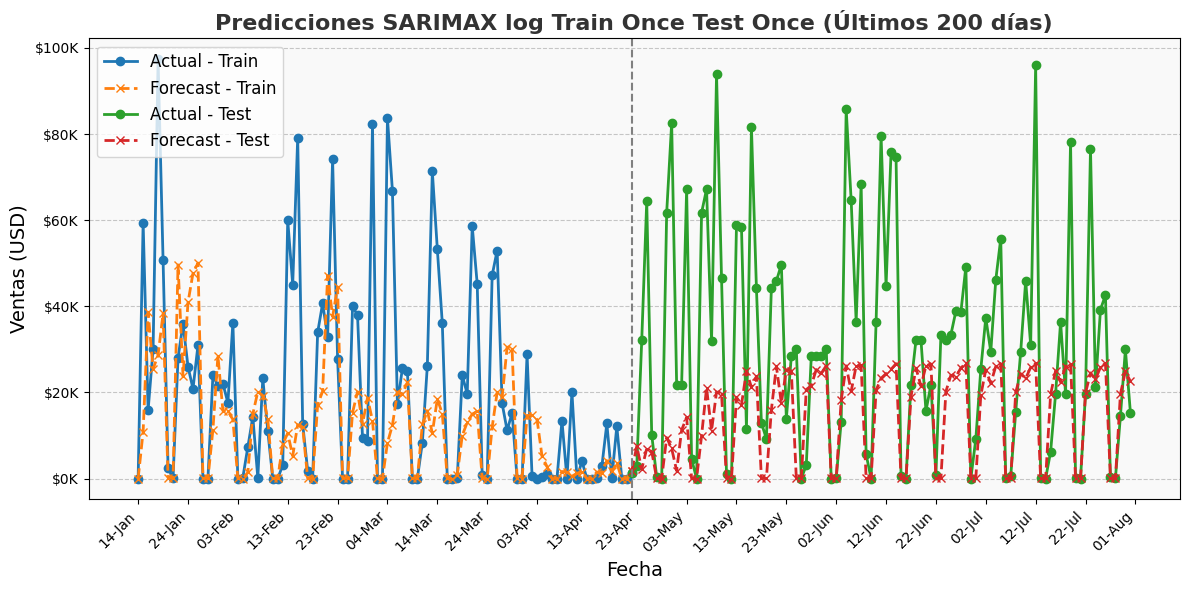

In [27]:
# Gráfica comparativa SARIMAX
plot_predictions(train_forecast_values_clipped, test_forecast_values_clipped, data, model_info,test_days=test_days)

El desemepeño en train fue peor que en la serie sin transformar, aunque en test fue mucho mejor. Sin embargo, se concluye que lo más probable es que haya overfitting, el modelo haya aprendido ciertos patrones y coinciden con el conjunto de test. El modelo sin transformar fue un poco más consistente.

### 3. Walk Forward

Este enfoque permite mejorar la calidad de las predicciones en el conjunto de test. Consiste en reentrenar iterativamente el modelo ampliando progresivamente el conjunto de entrenamiento con valores reales. 

#### 3.1. Serie sin transformar

In [28]:
train_data = data.iloc[:-test_days]
test_data = data.iloc[-test_days:]

# Variables exógenas
exog_train = exog[:-test_days]
exog_test = exog[-test_days:]

In [ ]:
# Inicializar las listas de predicciones y los datos históricos
predictions = []
history = data["Ventas"].iloc[:len(train_data)].tolist()  # datos históricos para iniciar el modelo
exog_history = exog_train.copy()  # copias de las exógenas en el conjunto de entrenamiento

# Validación Walk-forward en el conjunto de prueba
for t in range(len(test_data)):
    model = SARIMAX(history, order=best_order, seasonal_order=(1, 0, 1, 7), exog=exog_history)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1, exog=exog_test.iloc[t:t+1])[0]
    prediction = np.clip(yhat, 0, None)  # Asegurar que no haya valores negativos
    predictions.append(prediction)  # Almacenar la predicción en la lista de predicciones
    obs = test_data["Ventas"].iloc[t]
    history.append(obs)  # Actualizar los datos históricos con el valor observado
    exog_history = pd.concat([exog_history, exog_test.iloc[t:t+1]])  # Agregar la observación exógena al historial
    
    print(f'predicted={prediction}, expected={obs}')

# Usar las predicciones almacenadas en `predictions`
test_forecast_values_clipped = predictions

predicted=24767.44522178397, expected=1306.55
predicted=19799.920235418336, expected=2806.47
predicted=27780.09996154885, expected=32148.73
predicted=36104.49711611217, expected=64399.2
predicted=33149.3532054792, expected=10158.35
predicted=0.0, expected=317.24
predicted=0.0, expected=0.0
predicted=34190.30103829697, expected=61755.93
predicted=36774.765268830306, expected=82522.39
predicted=22276.097450897374, expected=21796.85
predicted=45698.84682190117, expected=21796.85
predicted=44673.68589914589, expected=67193.06
predicted=15906.01855679987, expected=4503.84
predicted=9110.790482320708, expected=0.0
predicted=36132.86764375235, expected=61755.93
predicted=44685.92816919262, expected=67193.06
predicted=51628.71279574702, expected=31844.5
predicted=42226.997997951534, expected=93945.95
predicted=52955.16392558497, expected=46671.37
predicted=18440.456528653434, expected=1077.44
predicted=7560.053866498545, expected=0.0
predicted=41415.50295670927, expected=58847.8
predicted=5120

In [ ]:
test_vs_actual = pd.DataFrame({
    'Actual': test_data["Ventas"].values,
    'Forecast': test_forecast_values_clipped
})

rmse_test = np.sqrt(mean_squared_error(test_data["Ventas"], test_forecast_values_clipped))
r2_test = r2_score(test_data["Ventas"], test_forecast_values_clipped)
mae_test = mean_absolute_error(test_data["Ventas"], test_forecast_values_clipped)

print(f'\nPredicciones en Test:\n{test_vs_actual}')
print(f'RMSE (Test): {rmse_test}')
print(f'R² (Test): {r2_test}')
print(f'MAE (Test): {mae_test}')


Predicciones en Test:
       Actual      Forecast
0     1306.55  24767.445222
1     2806.47  19799.920235
2    32148.73  27780.099962
3    64399.20  36104.497116
4    10158.35  33149.353205
..        ...           ...
96     305.76   9660.841258
97     114.40    603.706200
98   14466.95  34307.030950
99   29984.35  37196.875432
100  15335.34  37949.602470

[101 rows x 2 columns]
RMSE (Test): 20164.931808133195
R² (Test): 0.4026844005828757
MAE (Test): 15050.168519989958


In [31]:
# Almacenar la información del modelo
model_info = {
    'version': 'SARIMAX Walk-Forward',
    'model_name': sarimax_model.__class__.__name__,
    'rmse_train': rmse_train_1,
    'mae_train':mae_train_1,
    'r2_train': r2_train_1,
    'rmse_test': rmse_test,
    'mae_test':mae_test,
    'r2_test': r2_test,
}

In [32]:
# Agregar al dataframe
df_models_info = pd.concat([df_models_info, pd.DataFrame([model_info])], ignore_index=True)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,SARIMAX Train Once - Test Once,SARIMAX,20704.878394,15358.540698,0.450833,19801.859145,14742.087057,0.424000
1,SARIMAX log Train Once Test Once,SARIMAX,27199.614719,17453.110904,0.052270,26493.538408,17565.065774,-0.031075
2,SARIMAX Walk-Forward,SARIMAX,20704.878394,15358.540698,0.450833,20164.931808,15050.168520,0.402684


#### 3.2. Serie Transformada (Log)

In [33]:
train_data = data.iloc[:-test_days]
test_data = data.iloc[-test_days:]

# Variables exógenas
exog_train = exog_Log[:-test_days]
exog_test = exog_Log[-test_days:]

In [ ]:
# Inicializar las listas de predicciones y los datos históricos
predictions = []
history = data["Ventas_Log"].iloc[:len(train_data)].tolist()  # datos históricos para iniciar el modelo
exog_history = exog_train.copy()  # copias de las exógenas en el conjunto de entrenamiento

# Validación Walk-forward en el conjunto de prueba
for t in range(len(test_data)):
    model = SARIMAX(history, order=best_order_log, seasonal_order=(1, 0, 1, 7), exog=exog_history)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1, exog=exog_test.iloc[t:t+1])[0]
    prediction = np.clip(yhat, 0, None)  # Asegurar que no haya valores negativos
    predictions.append(prediction)  # Almacenar la predicción en la lista de predicciones
    obs = test_data["Ventas_Log"].iloc[t]
    history.append(obs)  # Actualizar los datos históricos con el valor observado
    exog_history = pd.concat([exog_history, exog_test.iloc[t:t+1]])  # Agregar la observación exógena al historial
    
    print(f'predicted={prediction}, expected={obs}')

# Usar las predicciones almacenadas en `predictions`
test_forecast_values_clipped = predictions

predicted=7.5499978899427145, expected=7.175910436125695
predicted=8.915821682494737, expected=7.940039000892105
predicted=7.479062715777082, expected=10.378159331496754
predicted=8.869635008855179, expected=11.072872017677684
predicted=9.101733132787233, expected=9.226149742707944
predicted=3.4326665129019034, expected=5.762805815105662
predicted=1.589607156757058, expected=0.0
predicted=9.607631952652499, expected=11.030961474913925
predicted=9.318794081543306, expected=11.320837047291462
predicted=8.649639728478563, expected=9.989566620060318
predicted=10.536142585729221, expected=9.989566620060318
predicted=10.707684671095702, expected=11.11534012974722
predicted=4.715081124722548, expected=8.412907653318497
predicted=3.074388393810475, expected=0.0
predicted=10.535586528293791, expected=11.030961474913925
predicted=11.153447016806819, expected=11.11534012974722
predicted=10.13297403446959, expected=10.368651363734177
predicted=10.612835094294212, expected=11.450485540238006
predic

In [35]:
# Deshacer la transformación logarítmica de las predicciones
test_forecast_values_original = [np.exp(pred) - 1 for pred in test_forecast_values_clipped]

# Deshacer la transformación logarítmica de los valores reales
test_actual_original = np.exp(test_data["Ventas_Log"]) - 1

# Crear el DataFrame de comparación
test_vs_actual = pd.DataFrame({
    'Actual': test_actual_original.values,
    'Forecast': test_forecast_values_original
})

# Calcular métricas de error
rmse_test = np.sqrt(mean_squared_error(test_actual_original, test_forecast_values_original))
r2_test = r2_score(test_actual_original, test_forecast_values_original)
mae_test = mean_absolute_error(test_actual_original, test_forecast_values_original)

# Imprimir resultados
print(f'\nPredicciones en Test:\n{test_vs_actual}')
print(f'RMSE (Test): {rmse_test}')
print(f'R² (Test): {r2_test}')
print(f'MAE (Test): {mae_test}')


Predicciones en Test:
       Actual      Forecast
0     1306.55   1899.738721
1     2806.47   7447.900246
2    32148.73   1769.580461
3    64399.20   7111.684433
4    10158.35   8969.826872
..        ...           ...
96     305.76    135.315009
97     114.40     10.632782
98   14466.95  28771.896628
99   29984.35  46397.303322
100  15335.34  27421.721162

[101 rows x 2 columns]
RMSE (Test): 26552.67851905519
R² (Test): -0.03568340198801012
MAE (Test): 17739.65292548016


In [36]:
# Almacenar la información del modelo
model_info = {
    'version': 'SARIMAX log Walk-Forward',
    'model_name': sarimax_model.__class__.__name__,
    'rmse_train': rmse_train_2,
    'mae_train':mae_train_2,
    'r2_train': r2_train_2,
    'rmse_test': rmse_test,
    'mae_test':mae_test,
    'r2_test': r2_test,
}

In [37]:
# Agregar al dataframe
df_models_info = pd.concat([df_models_info, pd.DataFrame([model_info])], ignore_index=True)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,SARIMAX Train Once - Test Once,SARIMAX,20704.878394,15358.540698,0.450833,19801.859145,14742.087057,0.424000
1,SARIMAX log Train Once Test Once,SARIMAX,27199.614719,17453.110904,0.052270,26493.538408,17565.065774,-0.031075
2,SARIMAX Walk-Forward,SARIMAX,20704.878394,15358.540698,0.450833,20164.931808,15050.168520,0.402684
3,SARIMAX log Walk-Forward,SARIMAX,27199.614719,17453.110904,0.052270,26552.678519,17739.652925,-0.035683


### 4. Exportar Resultados

In [38]:
ruta = r'C:\Users\fsanc\OneDrive - Universidad EAFIT\Documentos\Pipe\OneDrive - Universidad EAFIT\Maestría\Trabajo de Grado\Results\sarimax.csv'
df_models_info.to_csv(ruta, index=False)